In [5]:
## Creating code to compare chemical shifts from predicted by impression from the real data

In [6]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.Chem import AllChem
import os
import matplotlib.pyplot as plt


In [7]:

# Paths to folders
exp_folder = r"C:\Project_code\OUTPUT\10%"
pred_folder = r"C:\Project code\OUTPUT\Impressioned"

# Function to extract NMREDATA_ASSIGNMENT data from an SDF file
def extract_assignment_data(file_path):
    """Extracts NMREDATA_ASSIGNMENT data from an SDF file."""
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Find the index where NMREDATA_ASSIGNMENT starts and NMREDATA_J begins
    start_idx = next((i for i, line in enumerate(lines) if "> <NMREDATA_ASSIGNMENT>" in line), None)
    end_idx = next((i for i, line in enumerate(lines) if "> <NMREDATA_J>" in line), None)

    if start_idx is None or end_idx is None:
        return []

    # Extract relevant lines
    data_lines = lines[start_idx + 1:end_idx]
    
    # Process lines to extract the first two numbers from each line
    extracted_data = []
    for line in data_lines:
        values = line.strip().strip("\\").split(",")
        if len(values) >= 2:
            try:
                first_val = int(values[0].strip())  # Convert first value to integer
                second_val = float(values[1].strip())  # Convert second value to float
                extracted_data.append((first_val, second_val))
            except ValueError:
                continue  # Skip lines that don't match expected format

    return extracted_data

# Get list of molecule files in experimental folder
exp_files = [f for f in os.listdir(exp_folder) if f.endswith(".sdf")]

# Create a DataFrame to store comparisons
comparison_data = []

for exp_file in exp_files:
    # Define corresponding predicted file path
    pred_file = exp_file.replace(".nmredata.sdf", ".nmredata_predicted.sdf")
    pred_path = os.path.join(pred_folder, pred_file)
    exp_path = os.path.join(exp_folder, exp_file)

    if not os.path.exists(pred_path):
        print(f"Predicted file missing: {pred_file}")
        continue

    # Extract assignment data from both files
    exp_data = extract_assignment_data(exp_path)
    pred_data = extract_assignment_data(pred_path)

    # Ensure both files have comparable data
    min_length = min(len(exp_data), len(pred_data))
    
    # Store data for comparison, filtering out predicted values of 0.000000
    for i in range(min_length):
        if pred_data[i][1] != 0.0:  # Filter out rows where predicted value is 0
            comparison_data.append([exp_file, exp_data[i][0], exp_data[i][1], pred_data[i][0], pred_data[i][1]])

# Convert comparison data to a DataFrame
df = pd.DataFrame(comparison_data, columns=["Molecule", "Exp Index", "Exp Value", "Pred Index", "Pred Value"])

# Print as table
print(df.to_string(index=False))


Predicted file missing: molecule_105.nmredata_predicted.sdf
Predicted file missing: molecule_107.nmredata_predicted.sdf
Predicted file missing: molecule_110.nmredata_predicted.sdf
Predicted file missing: molecule_111.nmredata_predicted.sdf
Predicted file missing: molecule_12.nmredata_predicted.sdf
Predicted file missing: molecule_28.nmredata_predicted.sdf
Predicted file missing: molecule_42.nmredata_predicted.sdf
Predicted file missing: molecule_43.nmredata_predicted.sdf
Predicted file missing: molecule_8.nmredata_predicted.sdf
Predicted file missing: molecule_89.nmredata_predicted.sdf
Empty DataFrame
Columns: [Molecule, Exp Index, Exp Value, Pred Index, Pred Value]
Index: []


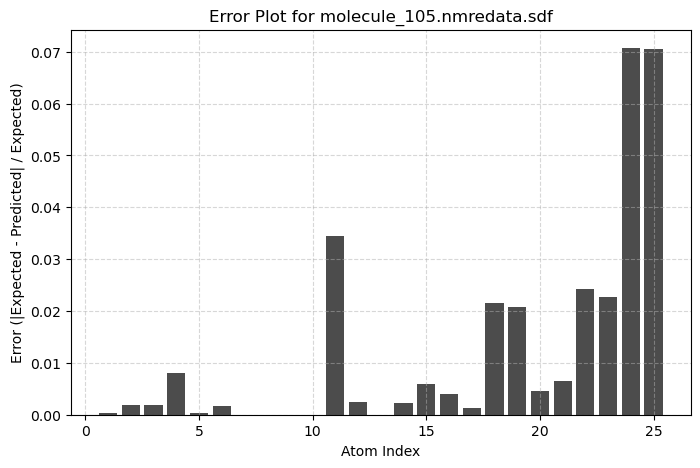

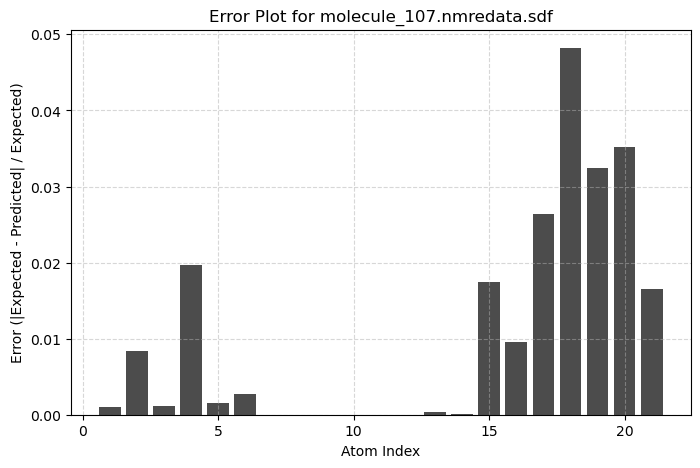

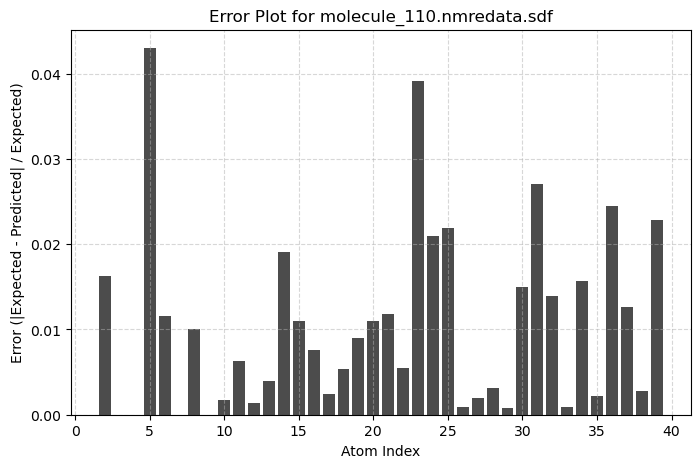

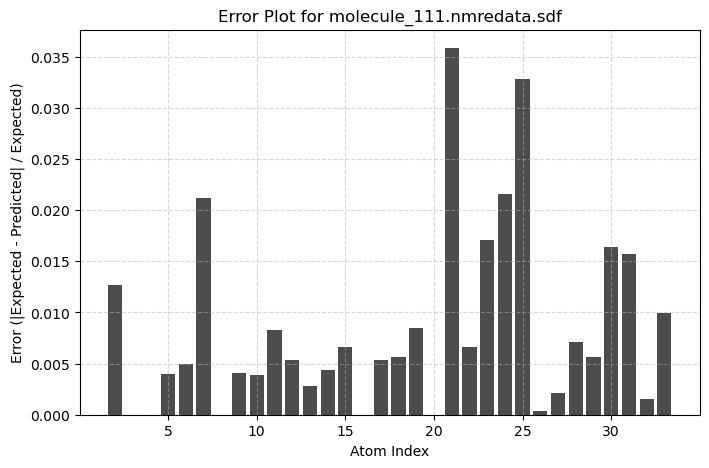

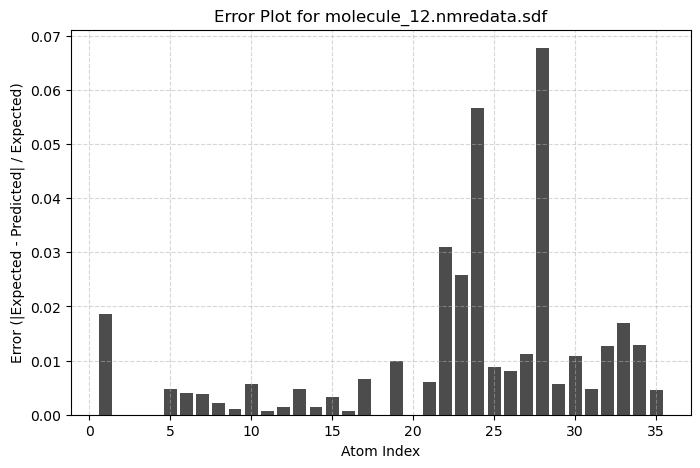

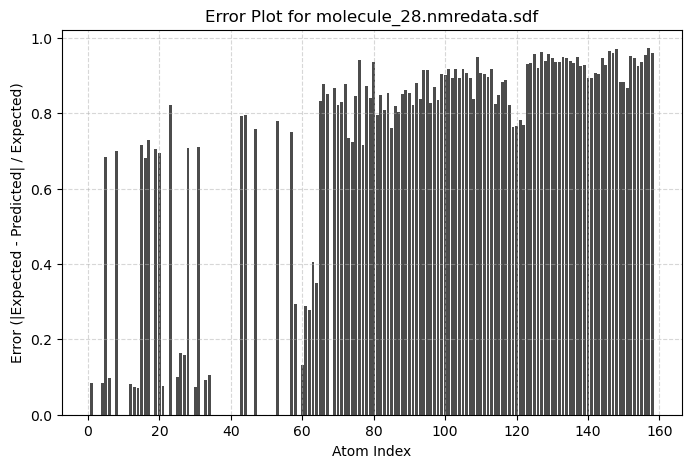

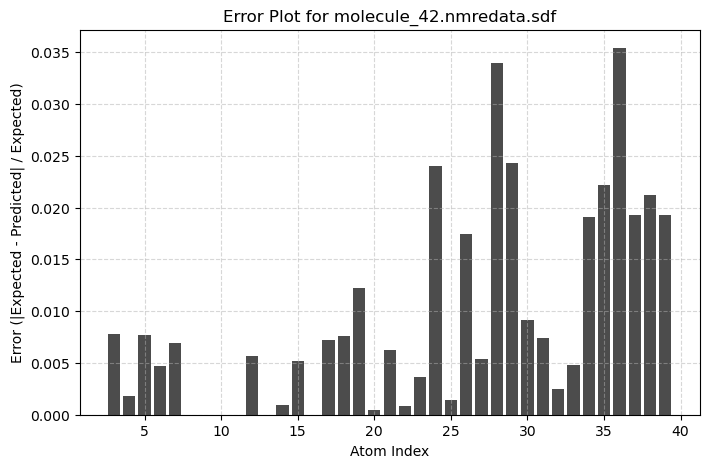

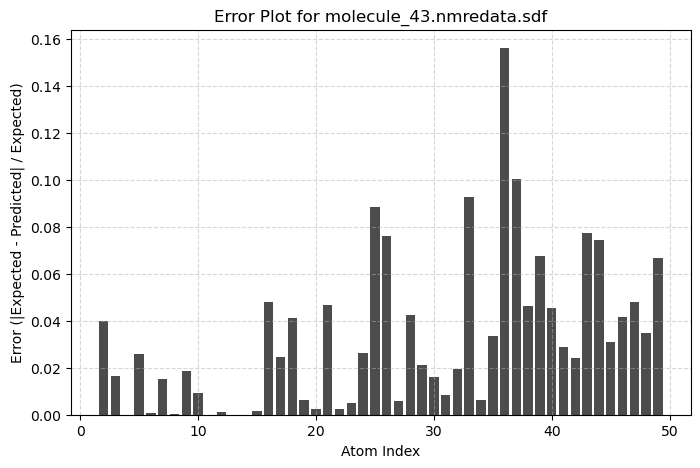

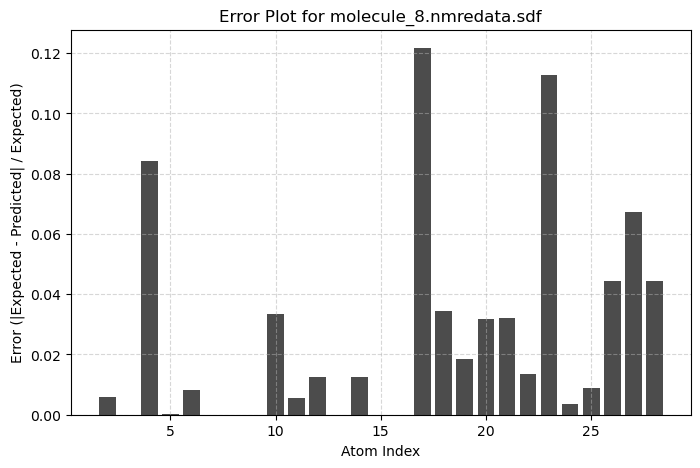

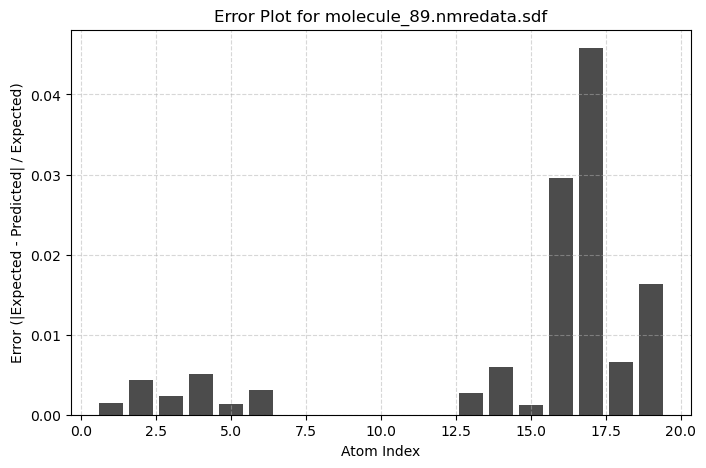

In [20]:
# Paths to folders
exp_folder = r"C:\Project_code\OUTPUT\10%"
pred_folder = r"C:\Project_code\OUTPUT\Impressioned"

## REMOVED ALL 0s from data

# Function to extract NMREDATA_ASSIGNMENT data from an SDF file
def extract_assignment_data(file_path):
    """Extracts NMREDATA_ASSIGNMENT data from an SDF file."""
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Find the index where NMREDATA_ASSIGNMENT starts and NMREDATA_J begins
    start_idx = next((i for i, line in enumerate(lines) if "> <NMREDATA_ASSIGNMENT>" in line), None)
    end_idx = next((i for i, line in enumerate(lines) if "> <NMREDATA_J>" in line), None)

    if start_idx is None or end_idx is None:
        return []

    # Extract relevant lines
    data_lines = lines[start_idx + 1:end_idx]
    
    # Process lines to extract the first two numbers from each line
    extracted_data = []
    for line in data_lines:
        values = line.strip().strip("\\").split(",")
        if len(values) >= 2:
            try:
                first_val = int(values[0].strip())  # Convert first value to integer (Atom index)
                second_val = float(values[1].strip())  # Convert second value to float (NMR shift)
                extracted_data.append((first_val, second_val))
            except ValueError:
                continue  # Skip lines that don't match expected format

    return extracted_data

# Get list of molecule files in experimental folder
exp_files = [f for f in os.listdir(exp_folder) if f.endswith(".sdf")]

# Store data for plotting
plot_data = {}

for exp_file in exp_files:
    # Define corresponding predicted file path
    pred_file = exp_file.replace(".nmredata.sdf", ".nmredata_predicted.sdf")
    pred_path = os.path.join(pred_folder, pred_file)
    exp_path = os.path.join(exp_folder, exp_file)

    if not os.path.exists(pred_path):
        print(f"Predicted file missing: {pred_file}")
        continue

    # Extract assignment data from both files
    exp_data = extract_assignment_data(exp_path)
    pred_data = extract_assignment_data(pred_path)

    # Ensure both files have comparable data
    min_length = min(len(exp_data), len(pred_data))

    # Store data for graphing
    atom_indices = []
    errors = []

    for i in range(min_length):
        exp_value = exp_data[i][1]
        pred_value = pred_data[i][1]

        if pred_value != 0.0:  # Exclude cases where predicted value is 0
            atom_indices.append(exp_data[i][0] + 1)  # Increment the atom index by 1
            errors.append(abs((exp_value - pred_value) / exp_value))  # Error (Expected - Predicted)/Expected

    plot_data[exp_file] = (atom_indices, errors)

# Generate graphs
for molecule, (atom_indices, errors) in plot_data.items():
    plt.figure(figsize=(8, 5))
    plt.bar(atom_indices, errors, color='black', alpha=0.7)
    plt.xlabel("Atom Index")
    plt.ylabel("Error (|Expected - Predicted| / Expected)")
    plt.title(f"Error Plot for {molecule}")
    plt.grid(True, linestyle="--", alpha=0.5)

    # Save plot (optional)
    plt.savefig(f"{molecule}_error_plot.png")

    # Show plot
    plt.show()


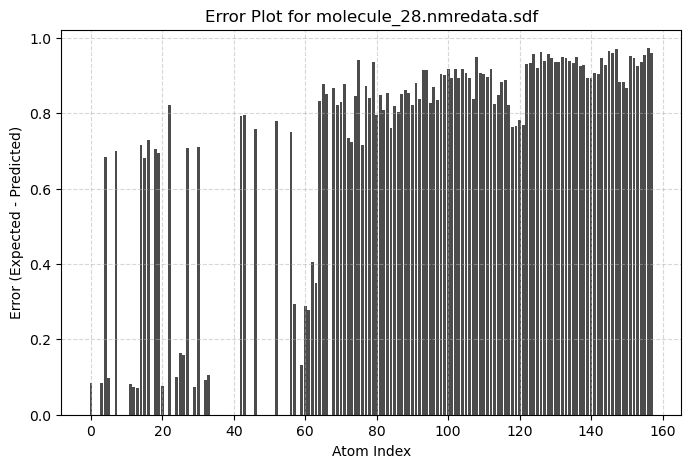

[13:59:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


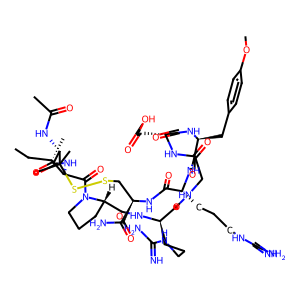

In [12]:
molecule_name = "molecule_28.nmredata.sdf"  # Change this to any molecule name

if molecule_name in plot_data:
    atom_indices, errors = plot_data[molecule_name]

    plt.figure(figsize=(8, 5))
    plt.bar(atom_indices, errors, color='black', alpha=0.7)
    plt.xlabel("Atom Index")
    plt.ylabel("Error (Expected - Predicted)")
    plt.title(f"Error Plot for {molecule_name}")
    plt.grid(True, linestyle="--", alpha=0.5)
    
    plt.show()
else:
    print(f"Molecule {molecule_name} not found in plot data.")




# Load the molecule from the SDF file
molecule_name = "C:/Project_code/OUTPUT/10%/molecule_28.nmredata.sdf"  # Change this path accordingly
supplier = Chem.SDMolSupplier(molecule_name)
molecule = supplier[0]  # Assuming there's only one molecule in the file

# Display the molecule structure
Draw.MolToImage(molecule)

In [17]:
import os

# Folder containing the SDF files (adjust this to your folder path)
folder_path = r"C:\Project_code\OUTPUT\10%"  # Change the folder path as needed

# The number to search for
search_number = "30.42222012"

# Function to read the content of an SDF file and count occurrences of the search number
def count_occurrences_in_sdf(file_path, search_number):
    count = 0
    num_atoms = 0  # Variable to store the number of atoms
    try:
        with open(file_path, 'r') as sdf_file:
            lines = sdf_file.readlines()
            # Get the number of atoms from the 4th line (index 3)
            num_atoms = int(lines[3].strip().split()[0])  # First number on the 4th line
            
            # Flag to check when we are under the > <NMREDATA_ASSIGNMENT> section
            in_assignment_section = False
            for line in lines:
                if "> <NMREDATA_ASSIGNMENT>" in line:  # Found the section
                    in_assignment_section = True
                elif "> <NMREDATA_J>" in line:  # End of the section
                    in_assignment_section = False
                elif in_assignment_section:
                    # Count occurrences of the search number in this section
                    count += line.count(search_number)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
    return num_atoms, count

# Loop through the files in the folder
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    
    # Process only the SDF files
    if file_name.endswith('.sdf'):  # Only process SDF files
        num_atoms, count = count_occurrences_in_sdf(file_path, search_number)
        
        # Print the result for each file
        print(f"In file '{file_name}', there are {num_atoms} atoms and {count} instances of {search_number}")


In file 'molecule_105.nmredata.sdf', there are 25 atoms and 0 instances of 30.42222012
In file 'molecule_107.nmredata.sdf', there are 21 atoms and 0 instances of 30.42222012
In file 'molecule_110.nmredata.sdf', there are 39 atoms and 0 instances of 30.42222012
In file 'molecule_111.nmredata.sdf', there are 33 atoms and 0 instances of 30.42222012
In file 'molecule_12.nmredata.sdf', there are 35 atoms and 0 instances of 30.42222012
In file 'molecule_28.nmredata.sdf', there are 158160 atoms and 78 instances of 30.42222012
In file 'molecule_42.nmredata.sdf', there are 39 atoms and 0 instances of 30.42222012
In file 'molecule_43.nmredata.sdf', there are 49 atoms and 0 instances of 30.42222012
In file 'molecule_8.nmredata.sdf', there are 28 atoms and 0 instances of 30.42222012
In file 'molecule_89.nmredata.sdf', there are 19 atoms and 0 instances of 30.42222012


In [21]:
import os

# Folder containing the SDF files
folder_path = r"C:\Project_code\OUTPUT\10%"  # Adjust as needed

# The number to search for
search_number = "30.42222012"

# Function to process an SDF file
def process_sdf(file_path, search_number):
    count = 0
    num_atoms_from_last_index = 0
    num_molecules_from_line_4 = 0

    try:
        with open(file_path, 'r') as sdf_file:
            lines = sdf_file.readlines()
            
            # Ensure at least 4 lines exist before extracting line 4
            if len(lines) >= 4:
                try:
                    num_molecules_from_line_4 = int(lines[3].strip().split()[0])  # First number on line 4
                except ValueError:
                    print(f"Warning: Unable to extract molecule count from line 4 in {file_path}")

            # Searching for the number in NMREDATA_ASSIGNMENT
            in_assignment_section = False
            last_valid_index = None  # Track last index before > <NMREDATA_J>

            for i, line in enumerate(lines):
                line = line.strip()
                
                if not line:  # Skip empty lines
                    continue
                
                if "> <NMREDATA_ASSIGNMENT>" in line:
                    in_assignment_section = True
                elif "> <NMREDATA_J>" in line:  
                    in_assignment_section = False  
                elif in_assignment_section:
                    count += line.count(search_number)  # Count occurrences

                    # Extract first number (index) from this line
                    parts = line.split(',')
                    if len(parts) > 0:
                        try:
                            last_valid_index = int(parts[0].strip())  # First value in the line
                        except ValueError:
                            continue  # Skip invalid lines

            # Ensure last index is found
            if last_valid_index is not None:
                num_atoms_from_last_index = last_valid_index + 1  # Atom count = last index + 1

    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
    
    return num_molecules_from_line_4, num_atoms_from_last_index, count

# Loop through all SDF files in the folder
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    
    if file_name.endswith('.sdf'):  
        num_molecules, num_atoms, count = process_sdf(file_path, search_number)


        # Print results for each file
        print(f"In {file_name}':")
        ##print(f"  Number of atoms from line 4: {num_molecules}")##This Isn't the right number of atoms, it's sometimes the first two numbers merged together
        print(f"  Number of atoms: {num_atoms}")
        print(f"  Instances of {search_number}: {count}")
        print("-" * 45)  # Separator for readability

In molecule_105.nmredata.sdf':
  Number of atoms: 25
  Instances of 30.42222012: 0
---------------------------------------------
In molecule_107.nmredata.sdf':
  Number of atoms: 21
  Instances of 30.42222012: 0
---------------------------------------------
In molecule_110.nmredata.sdf':
  Number of atoms: 39
  Instances of 30.42222012: 0
---------------------------------------------
In molecule_111.nmredata.sdf':
  Number of atoms: 33
  Instances of 30.42222012: 0
---------------------------------------------
In molecule_12.nmredata.sdf':
  Number of atoms: 35
  Instances of 30.42222012: 0
---------------------------------------------
In molecule_28.nmredata.sdf':
  Number of atoms: 158
  Instances of 30.42222012: 78
---------------------------------------------
In molecule_42.nmredata.sdf':
  Number of atoms: 39
  Instances of 30.42222012: 0
---------------------------------------------
In molecule_43.nmredata.sdf':
  Number of atoms: 49
  Instances of 30.42222012: 0
----------------